First, we stack spectra to get a (scaled) average spectrum, weighted equally between the two fits files (scaled firs then added rather than the other way around). 

In [1344]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request
import numpy as np
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

In [1345]:
data = []

def clean_and_normalize_spectrum(wave, flux, ivar):
    # Remove NaN and inf values
    good_idx = np.isfinite(flux) & np.isfinite(ivar)
    wave, flux, ivar = wave[good_idx], flux[good_idx], ivar[good_idx]
    
    # Simple normalization by median flux
    median_flux = np.median(flux)
    if median_flux != 0:
        flux = flux / median_flux
        ivar = ivar * (median_flux ** 2)
    
    return wave, flux, ivar

def load_spectrum(filename):
    with fits.open(filename) as hdul:
        coadd = hdul[1].data  # Extension 1 contains the spectrum
        flux = coadd['flux']
        loglam = coadd['loglam']
        ivar = coadd['ivar']

        
        # Convert log wavelength to linear wavelength (Angstroms)
        wavelength = 10**loglam
        wavelength, flux, ivar = clean_and_normalize_spectrum(wavelength, flux, ivar)
        return wavelength, flux, ivar

wave, flux, ivar = load_spectrum('fits_shortlist/spec-0273-51957-0005.fits') #data[0]
data.append([wave, flux, ivar])

wave, flux, ivar = load_spectrum('fits_shortlist/spec-0274-51913-0100.fits') # data[1]
data.append([wave, flux, ivar])


print(data[0][0][0])
print(data[1][0][0])

# Clearly we will need to do some aligning ...

3817.684
3797.519


In [1346]:
from scipy import interpolate

def resample_spectrum(wave, flux, ivar, new_wave):
    # Interpolate flux onto new wavelength grid
    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)
    new_flux = f(new_wave)
    
    # Interpolate ivar (need to handle this carefully)
    f_ivar = interpolate.interp1d(wave, ivar, bounds_error=False, fill_value=0)
    new_ivar = f_ivar(new_wave)
    
    return new_flux, new_ivar


In [1347]:
# Create common wavelength grid
wave_min = max([data[i][0][0] for i in range(len(data))])  # Maximum of all minimum wavelengths
wave_max = min([data[i][0][-1] for i in range(len(data))]) # Minimum of all maximum wavelengths
wave_common = np.linspace(wave_min, wave_max, num=3828)

# Resample all spectra
resampled_data = []
for spectrum in data:
   new_flux, new_ivar = resample_spectrum(spectrum[0], spectrum[1], spectrum[2], wave_common)
   resampled_data.append([wave_common, new_flux, new_ivar])
   


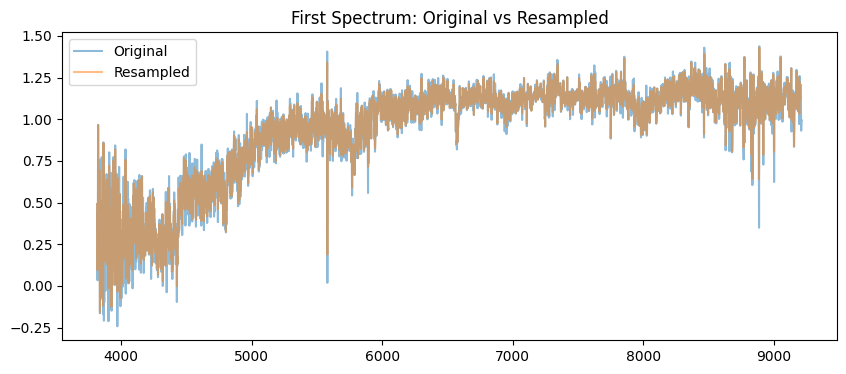

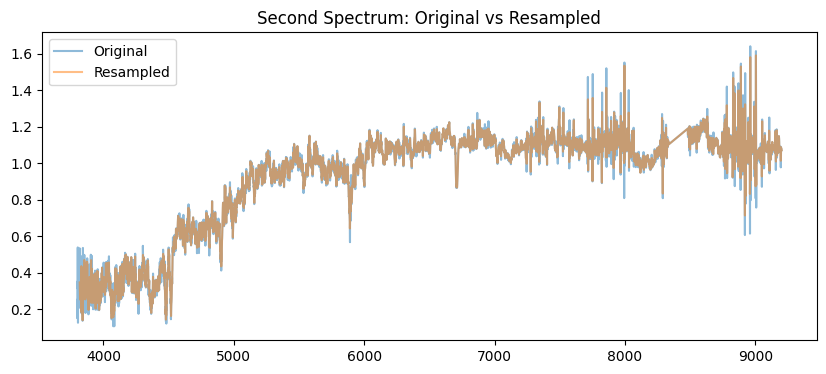

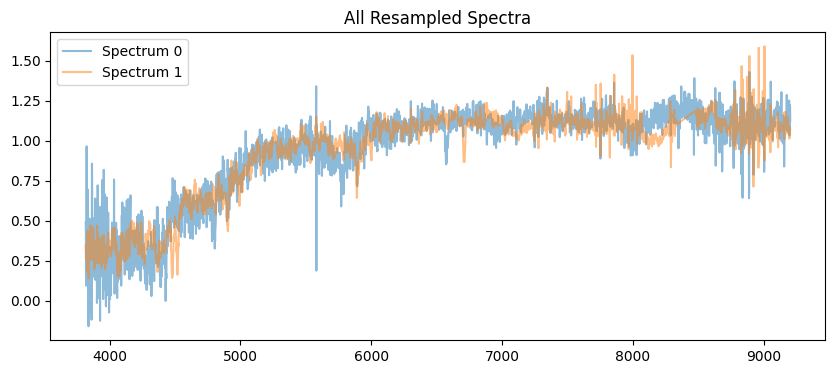

Common wavelength range: 3817.68 to 9202.38 Å
9202.379 9202.379


In [1348]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(data[0][0], data[0][1], label='Original', alpha=0.5)
plt.plot(resampled_data[0][0], resampled_data[0][1], label='Resampled', alpha=0.5)
plt.legend()
plt.title('First Spectrum: Original vs Resampled')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(data[1][0], data[1][1], label='Original', alpha=0.5)
plt.plot(resampled_data[1][0], resampled_data[1][1], label='Resampled', alpha=0.5)
plt.legend()
plt.title('Second Spectrum: Original vs Resampled')
plt.show()

# Plot all resampled spectra together
plt.figure(figsize=(10, 4))
for i, spectrum in enumerate(resampled_data):
    plt.plot(spectrum[0], spectrum[1], label=f'Spectrum {i}', alpha=0.5)
plt.legend()
plt.title('All Resampled Spectra')
plt.show()

# Print wavelength ranges
print(f"Common wavelength range: {wave_min:.2f} to {wave_max:.2f} Å")
print(resampled_data[0][0][-1], resampled_data[1][0][-1])

In [1349]:
"""now wavelengths should be the same, we just need to add the fluxes"""
# Handle divide by zero in error calculation
def safe_combine_ivar(ivar1, ivar2):
   # Where either ivar is 0 or inf, set combined ivar to 0
   mask = (ivar1 == 0) | (ivar2 == 0) | np.isinf(ivar1) | np.isinf(ivar2)
   combined = np.zeros_like(ivar1)
   valid = ~mask
   combined[valid] = 1.0 / (1.0/ivar1[valid] + 1.0/ivar2[valid])
   return combined

ivar = safe_combine_ivar(resampled_data[0][2], resampled_data[1][2])
lam_gal = resampled_data[0][0]
flux = (resampled_data[0][1]+ resampled_data[1][1])/2



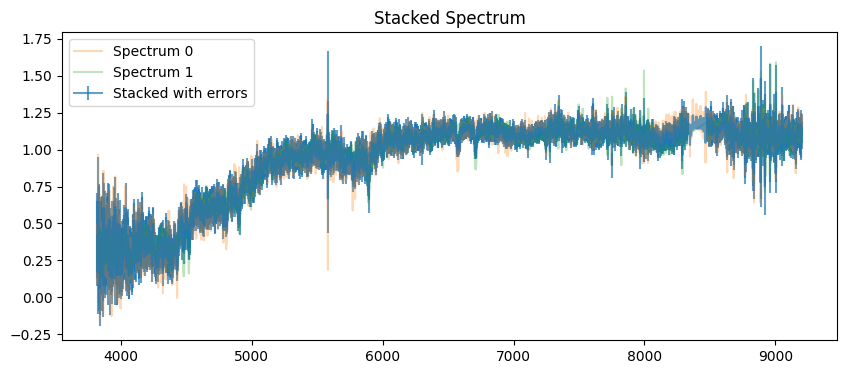

In [1350]:
def safe_errors(stacked_ivar):
   errors = np.zeros_like(stacked_ivar)
   valid = (stacked_ivar > 0) & np.isfinite(stacked_ivar)
   errors[valid] = 1.0 / np.sqrt(stacked_ivar[valid])
   return errors

errors = safe_errors(ivar)

plt.figure(figsize=(10, 4))
plt.errorbar(resampled_data[0][0], flux, label='Stacked with errors', alpha=0.7 ,yerr=errors)
plt.plot(resampled_data[0][0], resampled_data[0][1], label='Spectrum 0', alpha=0.3)
plt.plot(resampled_data[0][0], resampled_data[1][1], label='Spectrum 1', alpha=0.3)
plt.legend()
plt.title('Stacked Spectrum')
plt.show()

Now we fit ppxf as normal. I use example "ppxf_example)gas_sdss_tied.ipynb" for guidance / example. 

In [1351]:
c = 299792.458 # speed of light in km/s
ln_lam_gal = np.log(lam_gal)  # Natural logarithm
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
noise = np.full_like(flux, 0.01635)           # Assume constant noise per pixel here

In [1352]:
dlam_gal = np.gradient(lam_gal)  # Size of every pixel in Angstroms

hdul = fits.open('fits_shortlist/spec-0273-51957-0005.fits')
coadd = hdul[1].data 
wdisp = coadd['wdisp']  # assuming that the wdisp is constant between the two spectra for now.

fwhm_gal = 2.355*wdisp*dlam_gal 

In [1353]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

In [1354]:
basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = Path(lib.__file__).parent
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)




lam_range_gal = np.array([np.min(lam_gal), np.max(lam_gal)])/(1+1) # should be 1+redshift here - what to do for stacked spectra? Using 1 as a default
gas_templates, gas_names, gas_wave = \
    util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)
templates = np.column_stack([stars_templates, gas_templates])
n_temps = stars_templates.shape[1]
print(len(gas_names))

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' '[OII]3726' '[OII]3729'
 '[NeIII]3968' '[NeIII]3869']
10


In [1355]:
component = [0]*n_temps  # Single stellar kinematic component=0 for all templates
component += [1]*6
component += [2, 2, 3, 4]
component = np.array(component)
moments = [2]*len(np.unique(component))

print(component.shape)
print(templates.shape)
vel0 = c * np.log(1 + 1)  # redshift meant to be in here too, using 1 as default?
sol = [vel0, 200]
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars

(160,)
(14760, 160)


In [1356]:
"""tied = [['', ''] for j in range(len(moments))]
for j in range(3, len(moments)):
    tied[j][0] = 'p[4]'"""

#          V0 s0 V1 s1 V2 s2 V3 s3 V4 s4 V5 s5 V6 s6 V7 s7 V8 s8
"""A_ineq = [[0, -2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # -2*s0 + s1 < 0 => s1 < 2*s0
          [0, -2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s2 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s3 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # s4 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # s5 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # s6 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # s7 < 2*s0
          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]  # s8 < 2*s0
b_ineq = [0, 0, 0, 0, 0, 0, 0, 0]
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}"""

'A_ineq = [[0, -2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # -2*s0 + s1 < 0 => s1 < 2*s0\n          [0, -2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s2 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # s3 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # s4 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # s5 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # s6 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # s7 < 2*s0\n          [0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]  # s8 < 2*s0\nb_ineq = [0, 0, 0, 0, 0, 0, 0, 0]\nconstr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}'

(14760, 160)
 Best Fit:       Vel     sigma
 comp.  0:    209800      1000
 comp.  1:    205800      1000
 comp.  2:    207800       200
 comp.  3:    209014      1000
 comp.  4:    205800      1000
chi2/DOF: 157.0; DOF: 3808; degree = -1; mdegree = 10
method = capfit; Jac calls: 11; Func calls: 233; Status: 3
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/160
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10      52.03      0.12  205800  1000
Comp:  1                    H9      19.82      0.12  205800  1000
Comp:  1                    H8      6.264      0.14  205800  1000
Comp:  1                  Heps      6.006      0.12  205800  1000
Comp:  1                Hdelta      0.000      0.12  205800  1000
Comp:  1                Hgamma      2.756      0.12  205800  1000
Comp:  2             [OII]3726      

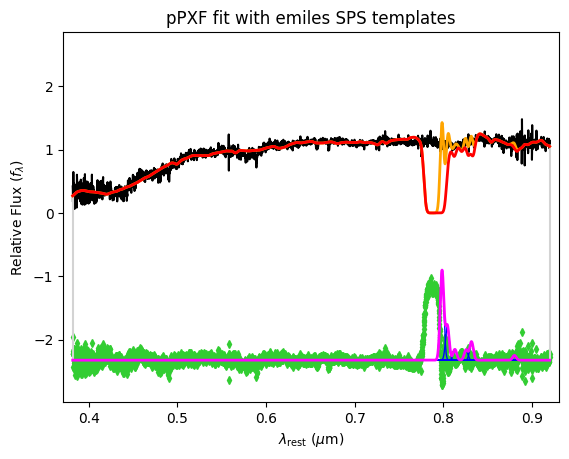

In [1357]:
degree= -1
mdegree = 10
t = clock()

print(templates.shape)

pp = ppxf(templates, flux, noise, velscale, start, plot=False, # changed "galaxy" to flux here
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, 
            gas_component=component > 0, gas_names=gas_names,
            lam_temp=sps.lam_temp)

# removed tied and inequality constraints 

"""pp = ppxf(templates, flux, noise, velscale, start, plot=False, # changed galaxy to flux here
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, tied=tied, 
            gas_component=component > 0, gas_names=gas_names,
            constr_kinem=constr_kinem, lam_temp=sps.lam_temp)"""


print(f"Elapsed time in pPXF: {(clock() - t):.2f}")
pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")
plt.pause(5)